In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

EJERCICIO 1

In [ ]:
def impulsivo(val0,prob0,val1,prob1,val2,size):
    arr = np.zeros(size)
    n_ib = cv.randu(arr,0,1)
    for i in np.arange(size[0]):
        for j in np.arange(size[1]):
            if n_ib[i,j] <=prob0:
                n_ib[i,j] = val0
            elif n_ib[i,j]>prob0 and n_ib[i,j]<prob0+prob1:
                n_ib[i,j] = val1
            else:
                n_ib[i,j] = val2
    return n_ib

def mse(imageA, imageB): 
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2) 
    err /= float(imageA.shape[0] * imageA.shape[1]) 
    return err

In [ ]:
#gaussian noise
im0 = np.zeros((600,600))
n_g = cv.randn(np.copy(im0),100,10)
n_g_n = np.uint8(cv.normalize(np.copy(n_g),np.copy(n_g), 0, 255, cv.NORM_MINMAX))

#uniform noise
n_u = cv.randu(np.copy(im0),-5,5)
n_u_n = np.uint8(cv.normalize(np.copy(n_u),np.copy(n_u), 0, 255, cv.NORM_MINMAX))

#salt and pepper
n_sp = impulsivo(0,.2,255,.5,127,im0.shape)

#histograms
hist_n_g_n = cv.calcHist([n_g_n], [0], None, [256], [0,256])
hist_n_u_n = cv.calcHist([n_u_n], [0], None, [256], [0,256])
hist_n_sp = cv.calcHist([np.uint8(n_sp)], [0], None, [256], [0,256])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10)) 
ax[0,1].bar(range(256),np.squeeze(hist_n_g_n))
ax[0,0].imshow(n_g_n,cmap='gray',vmin=0,vmax=255)

ax[1,1].bar(range(256),np.squeeze(hist_n_u_n))
ax[1,0].imshow(n_u_n,cmap='gray',vmin=0,vmax=255)

ax[2,1].bar(range(256),np.squeeze(hist_n_sp))
ax[2,0].imshow(n_sp,cmap='gray',vmin=0,vmax=255)
plt.show()

In [ ]:
im1 = np.zeros((600,600))
im1[:,0:200] = 180
im1[:,200:400] = 120
im1[:,400:600] = 60

#noising
im1_n_g_n = im1 + np.random.normal(0, 7, (im1.shape[0],im1.shape[1]))
im1_n_u_n = im1 + np.random.uniform(-10,10, (im1.shape[0],im1.shape[1]))
n_i = impulsivo(1,.15,255,.15,0,im1.shape)
im1_n_sp = np.where(n_i > 0, n_i, im1)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(im1,cmap='gray',vmin=0,vmax=255)
ax[0,1].hist(im1.ravel(),256,[0,256])

ax[1,0].imshow(im1_n_g_n,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(im1_n_g_n.ravel(),256,[0,256])

ax[2,0].imshow(im1_n_u_n,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(im1_n_u_n.ravel(),256,[0,256])

ax[3,0].imshow(im1_n_sp,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(im1_n_sp.ravel(),256,[0,256])
plt.show()

EJERCICIO 2

In [ ]:
def geometric_mean_filter(image, filter_size):
    # Obtener el tamaño de la imagen
    im_H, im_W = image.shape
    #aplica filtro media geométrica, im -> im_f_mg
    filter_size = 3
    padsize = (filter_size-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,1).astype(np.float64)

    im_f_mg = np.zeros(image.shape)

    for i in range(im_H):
        for j in range(im_W):
            im_f_mg[i, j] = np.prod(im_p[i:i+filter_size,j:j+filter_size])**(1/(filter_size**2))

    return im_f_mg

def contrarmonic_filter(image, ksize,Q):

    # Obtener el tamaño de la imagen
    im_H, im_W = image.shape

    ksize = 3
    padsize = (ksize-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)

    im_f_mch = np.zeros(image.shape)
    for i in range(im_H):
        for j in range(im_W):
            im_f_mch[i, j] = np.sum(im_p[i:i+ksize,j:j+ksize]**(Q+1))/(np.sum(im_p[i:i+ksize,j:j+ksize]**Q))

    return im_f_mch

In [ ]:
sangre = cv.imread('imagenes/sangre.jpg', cv.IMREAD_GRAYSCALE)

gaussian = np.random.normal(0, 20, (sangre.shape[0],sangre.shape[1])).astype(np.uint8)
imp_noise = impulsivo(50,0,240,0.15,0,sangre.shape).astype(np.uint8)

sangre_noise_g = sangre+gaussian
sangre_noise_imp = np.where(imp_noise > 0,imp_noise,sangre)
sangre_filtrada = geometric_mean_filter(sangre_noise_g,3)

sangre_filtrada_2 = contrarmonic_filter(sangre_noise_imp,3,1)

print("MSE Degradada (Gauss) - Limpia: ",mse(sangre,sangre_noise_g))
print("MSE Filtrada (GeoMean) - Limpia: ",mse(sangre,sangre_filtrada))
print("\n")
print("MSE Degradada (Imp) - Limpia: ",mse(sangre,sangre_noise_imp))
print("MSE Filtrada (ContArm) - Limpia: ",mse(sangre,sangre_filtrada_2))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(sangre,cmap='gray')
ax[0,1].hist(sangre.ravel(),256,[0,256])

ax[1,0].imshow(sangre_noise_g,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(sangre_noise_g.ravel(),256,[0,256])

ax[2,0].imshow(sangre_filtrada,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(sangre_filtrada.ravel(),256,[0,256])

ax[3,0].imshow(sangre_noise_imp,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(sangre_noise_imp.ravel(),256,[0,256])

ax[4,0].imshow(sangre_filtrada_2,cmap='gray',vmin=0,vmax=255)
ax[4,1].hist(sangre_filtrada_2.ravel(),256,[0,256])
plt.show()


# ejercicio 3

In [364]:
def punto_medio(image, kernel_size):
    im_H, im_W = image.shape
    im_f_mch = np.zeros(image.shape)

    padsize = (kernel_size-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)
    for i in range(im_H):
        for j in range(im_W):
            im_f_mch[i, j] = (np.min(im_p[i:i+kernel_size,j:j+kernel_size]) + np.max(im_p[i:i+kernel_size,j:j+kernel_size]))//2
    return im_f_mch

def alfa_recortado(image, kernel_size,d):
    im_H, im_W = image.shape
    im_f_mch = np.zeros(image.shape)

    padsize = (kernel_size-1)//2

    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)

    for i in range(im_H):
        for j in range(im_W):
            S = np.sort(im_p[i:i+kernel_size,j:j+kernel_size].flatten())
            S = S[d//2:S.shape[0]-d//2]
            im_f_mch[i, j] = np.sum(S)/S.shape[0]
    return im_f_mch


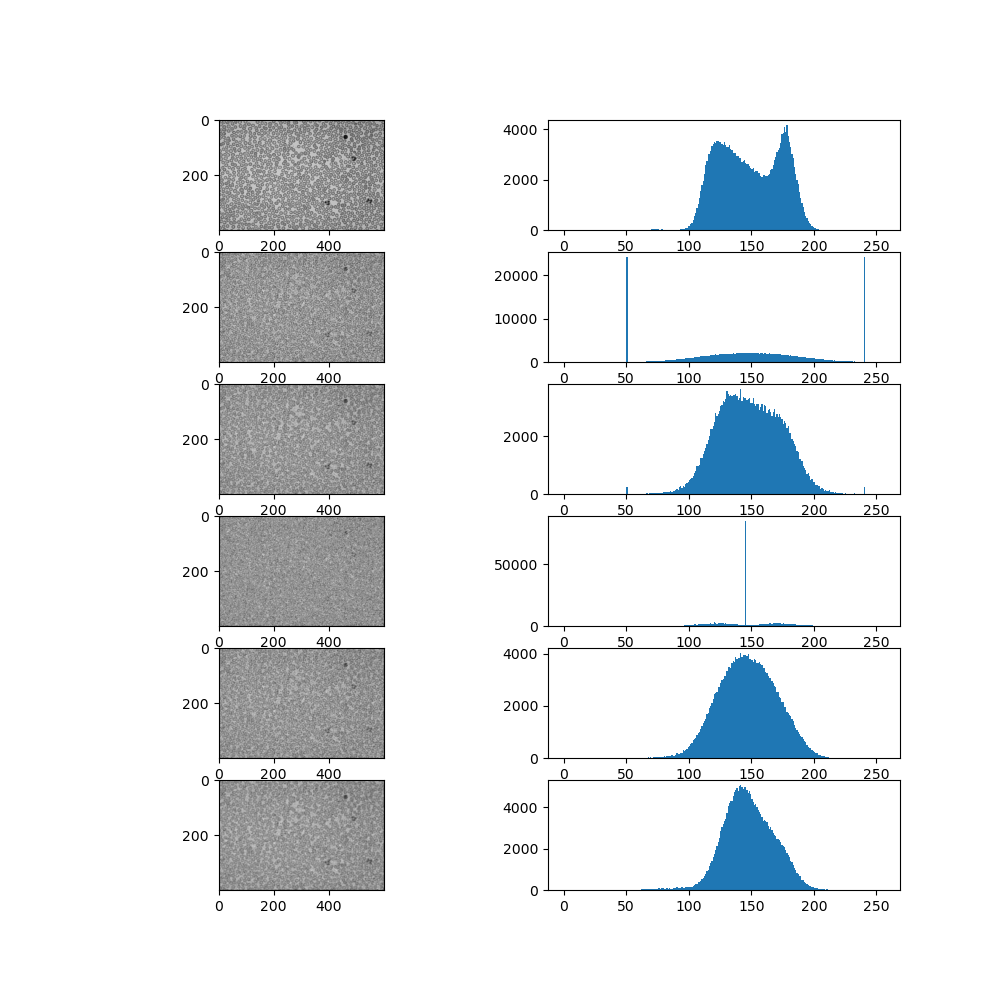

MSE Degradada - Limpia:  2438.9795291666665
MSE Filtrada (Median) - Limpia:  307.62594583333333
MSE Filtrada (Pto Medio) - Limpia:  828.7170666666667
MSE Filtrada (Alfa Recortado) - Limpia:  407.27446275720155
MSE Filtrada (Mix) - limpia:  334.9564875


In [184]:
sangre = cv.imread('imagenes/sangre.jpg', cv.IMREAD_GRAYSCALE)

gaussian = np.random.normal(0, 25, (sangre.shape[0],sangre.shape[1])).astype(np.uint8)
imp_noise = impulsivo(50,0.1,240,0.1,0,sangre.shape).astype(np.uint8)
sangre_noise_g = sangre+gaussian
sangre_noise_imp = np.where(imp_noise > 0,imp_noise,sangre)
sangre_imp_g = np.where(imp_noise > 0,imp_noise,sangre_noise_g)


sangre_median = cv.medianBlur(sangre_imp_g,3)
sangre_ptomedio = punto_medio(sangre_imp_g, 3)
sangre_recortado = alfa_recortado(sangre_imp_g,3,1)

sangre_mix=punto_medio(cv.medianBlur(sangre_imp_g,3),3)

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(sangre,cmap='gray')
ax[0,1].hist(sangre.ravel(),256,[0,256])

ax[1,0].imshow(sangre_imp_g,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(sangre_imp_g.ravel(),256,[0,256])

ax[2,0].imshow(sangre_median,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(sangre_median.ravel(),256,[0,256])

ax[3,0].imshow(sangre_ptomedio,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(sangre_ptomedio.ravel(),256,[0,256])

ax[4,0].imshow(sangre_recortado,cmap='gray',vmin=0,vmax=255)
ax[4,1].hist(sangre_recortado.ravel(),256,[0,256])

ax[5,0].imshow(sangre_mix,cmap='gray',vmin=0,vmax=255)
ax[5,1].hist(sangre_mix.ravel(),256,[0,256])
plt.show()


print("MSE Degradada - Limpia: ",mse(sangre,sangre_imp_g))
print("MSE Filtrada (Median) - Limpia: ",mse(sangre,sangre_median))
print("MSE Filtrada (Pto Medio) - Limpia: ",mse(sangre,sangre_ptomedio))
print("MSE Filtrada (Alfa Recortado) - Limpia: ",mse(sangre,sangre_recortado))
print("MSE Filtrada (Mix) - limpia: ",mse(sangre,sangre_mix))

# ejercicio 5

In [305]:
def dist(a,b):
    """distancia Euclidea"""
    return np.linalg.norm(np.array(a)-np.array(b))

def filterGaussian(rows,cols,corte):
    """Filtro de magnitud gausiano"""

    magnitud = np.zeros((rows, cols))

    corte *= rows
    for k in range(rows):
        for l in range(cols):
            magnitud[k,l]=np.exp(-dist([k+.5,l+.5],[rows/2,cols/2])/2/corte/corte)
            
    return np.fft.fftshift(magnitud)
    
        
def filterIdeal(rows, cols, corte):
    """filtro de magnitud ideal"""
    magnitud = np.zeros((rows, cols))
    if cols%2==1 and rows%2==1: #impar, el centro cae en un píxel
        print('entro')
        magnitud=cv.circle(magnitud, (cols/2,rows/2), rows*corte, 1, -1)
    else:
        limit = (corte*rows)**2
        for k in range(rows):
            for l in range(cols):
                d2 = dist([k+.5,l+.5],[rows/2,cols/2])
                if d2 <= limit: 
                    magnitud[k,l] = 1
    return np.fft.fftshift(magnitud)
	
def filterButterworth(rows, cols, corte, order):
    """filtro de magnitud Butterworth"""
    #corte = w en imagen de lado 1
    #1 \over 1 + {D \over w}^{2n}
    magnitud = np.zeros((rows, cols))
    corte *= rows;
    for k in range(rows):
        for l in range(cols):
            d2 = dist([k+.5,l+.5],[rows/2,cols/2])
            magnitud[k,l] = 1.0/(1 + (d2/corte/corte)**order)

    return np.fft.fftshift(magnitud)

def filterButterworth2(rows, cols,rowstart,colstart, corte, order):
    """filtro de magnitud Butterworth"""
    #corte = w en imagen de lado 1
    #1 \over 1 + {D \over w}^{2n}
    magnitud = np.zeros((rows, cols))
    corte *= rows;
    for k in range(rows):
        for l in range(cols):
            d2 = dist([k+.5,l+.5],[rowstart,colstart])
            magnitud[k,l] = 1.0/(1 + (d2/corte/corte)**order)

    return np.fft.fftshift(magnitud)


def spectrum(img):
    """Calcula y muestra el módulo logartímico de la DFT de img."""
    #img=optimalDFTImg(img)
    
    imgf=cv.dft(np.float32(img),flags=cv.DFT_COMPLEX_OUTPUT) 
    modulo = np.log(cv.magnitude(imgf[:,:,0],imgf[:,:,1])+1)
    modulo = np.fft.fftshift(modulo) 
    modulo=cv.normalize(modulo, modulo, 0, 1, cv.NORM_MINMAX)
    
    return modulo

def filterImg(img,filtro_magnitud):
    """Filtro para imágenes de un canal"""
    
    
    #como la fase del filtro es 0 la conversión de polar a cartesiano es directa (magnitud->x, fase->y)
    filtro=np.array([filtro_magnitud,np.zeros(filtro_magnitud.shape)]).swapaxes(0,2).swapaxes(0,1)
    imgf=cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
   
    imgf=cv.mulSpectrums(imgf, np.float32(filtro), cv.DFT_ROWS)
    
    return cv.idft(imgf, flags=cv.DFT_REAL_OUTPUT | cv.DFT_SCALE)

MSE Degradada - Limpia:  3522.132110595703
MSE Filtrada (rechaza-banda) - Limpia:  1546.2529961078637
MSE Filtrada (butter) - Limpia:  2052.020810540822
MSE Filtrada (notch-ideal) - Limpia:  1542.7866179362604
MSE Filtrada (notch-butter) - limpia:  1535.9265809269218
MSE Filtrada (pasabajo) - limpia:  2140.512227377732


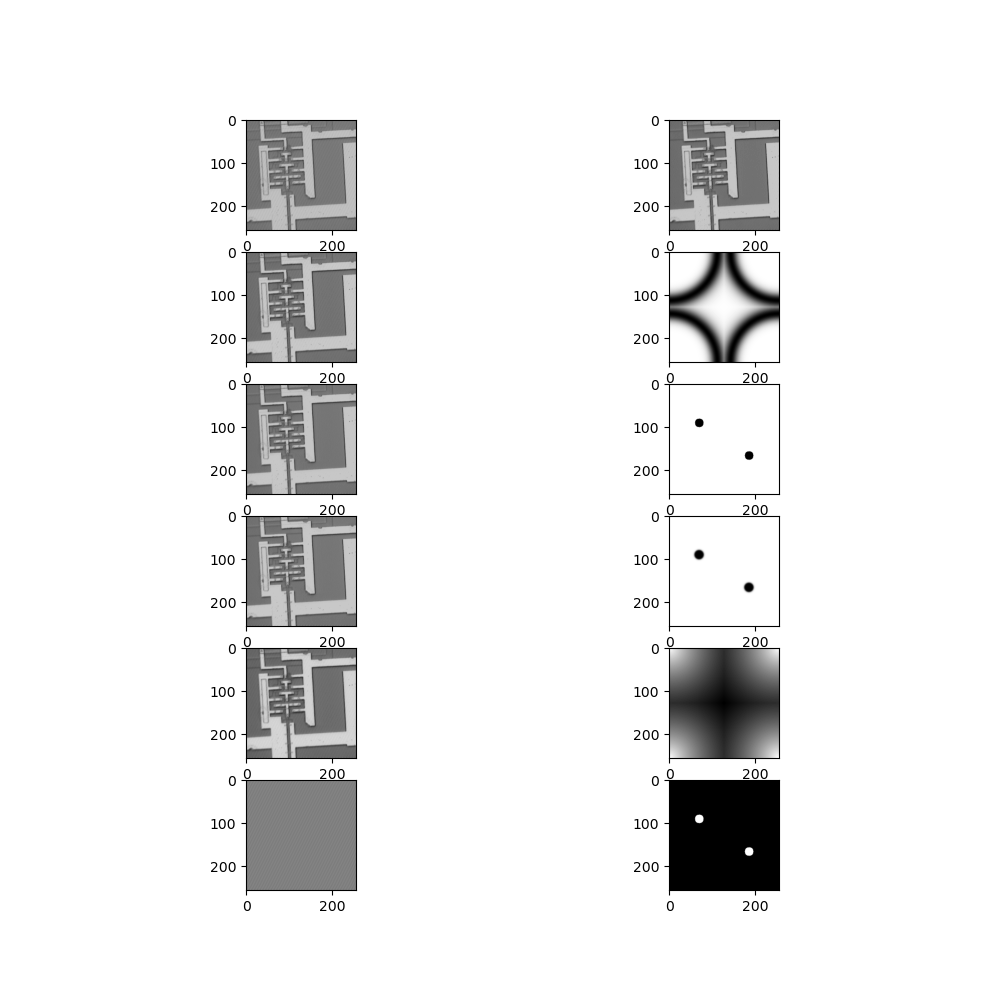

In [324]:
imagen = cv.imread("imagenes/img_degradada.tif",cv.IMREAD_GRAYSCALE)

imagenfft = np.fft.fft2(imagen)
imagenfft = np.fft.fftshift(imagenfft)
imagenfft = cv.magnitude(np.real(imagenfft),np.imag(imagenfft))
imagenfft = np.log(imagenfft)

H,W=imagen.shape
delta=15
copia = np.copy(imagenfft)
copia[H//2-delta:H//2+delta,W//2-delta:W//2+delta]=0

x0,y0 = cv.minMaxLoc(copia)[3]
# print(x0,y0,'y',256-x0,256-y0)

rechazaBanda = 1-filterIdeal(H,W,0.043)+filterIdeal(H,W,0.04) #Ideal
img_rb = filterImg(imagen,rechazaBanda)

butterBanda = 1-filterButterworth(H,W,0.043,15)+filterButterworth(H,W,0.04,15)
img_butter = filterImg(imagen,butterBanda)

copia2=np.zeros((H,W))

notchIdeal = cv.circle(copia2,(x0,y0),10,1,-1)
notchIdeal = cv.circle(notchIdeal,(H-x0,W-y0),10,1,-1)
notchIdeal = abs(1-notchIdeal)
notchIdeal = np.fft.ifftshift(notchIdeal)
img_notchI = filterImg(imagen,notchIdeal)


notchButter2 = abs(1-filterButterworth2(H,W,y0,x0,0.013,13)) * abs(1-filterButterworth2(H,W,H-y0,W-x0,0.013,13))
img_notchB = filterImg(imagen,notchButter2)

pasabajo = filterGaussian(H,W,0.033)
img_pasbajo = filterImg(imagen,pasabajo)

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(imagen,cmap="gray")
ax[0,1].imshow(img_rb,cmap="gray")

ax[1,0].imshow(img_butter,cmap="gray")
ax[1,1].imshow(butterBanda,cmap="gray")

ax[2,0].imshow(img_notchI,cmap="gray")
ax[2,1].imshow(notchIdeal,cmap="gray")

ax[2,0].imshow(img_notchI,cmap="gray")
ax[2,1].imshow(notchIdeal,cmap="gray")

ax[3,0].imshow(img_notchB,cmap="gray")
ax[3,1].imshow(notchButter2,cmap="gray")

ax[4,0].imshow(img_pasbajo,cmap="gray")
ax[4,1].imshow(pasabajo,cmap="gray")



img_og = cv.imread("imagenes/img.tif",cv.IMREAD_GRAYSCALE)

print("MSE Degradada - Limpia: ",mse(img_og,imagen))
print("MSE Filtrada (rechaza-banda) - Limpia: ",mse(img_og,img_rb))
print("MSE Filtrada (butter) - Limpia: ",mse(img_og,img_butter))
print("MSE Filtrada (notch-ideal) - Limpia: ",mse(img_og,img_notchI))
print("MSE Filtrada (notch-butter) - limpia: ",mse(img_og,img_notchB))
print("MSE Filtrada (pasabajo) - limpia: ",mse(img_og,img_pasbajo))

notch_pasante = abs(1-notchIdeal)
img_notchP = filterImg(imagen,notch_pasante)

ax[5,0].imshow(img_notchP,cmap="gray")
ax[5,1].imshow(notch_pasante,cmap="gray")
plt.show()

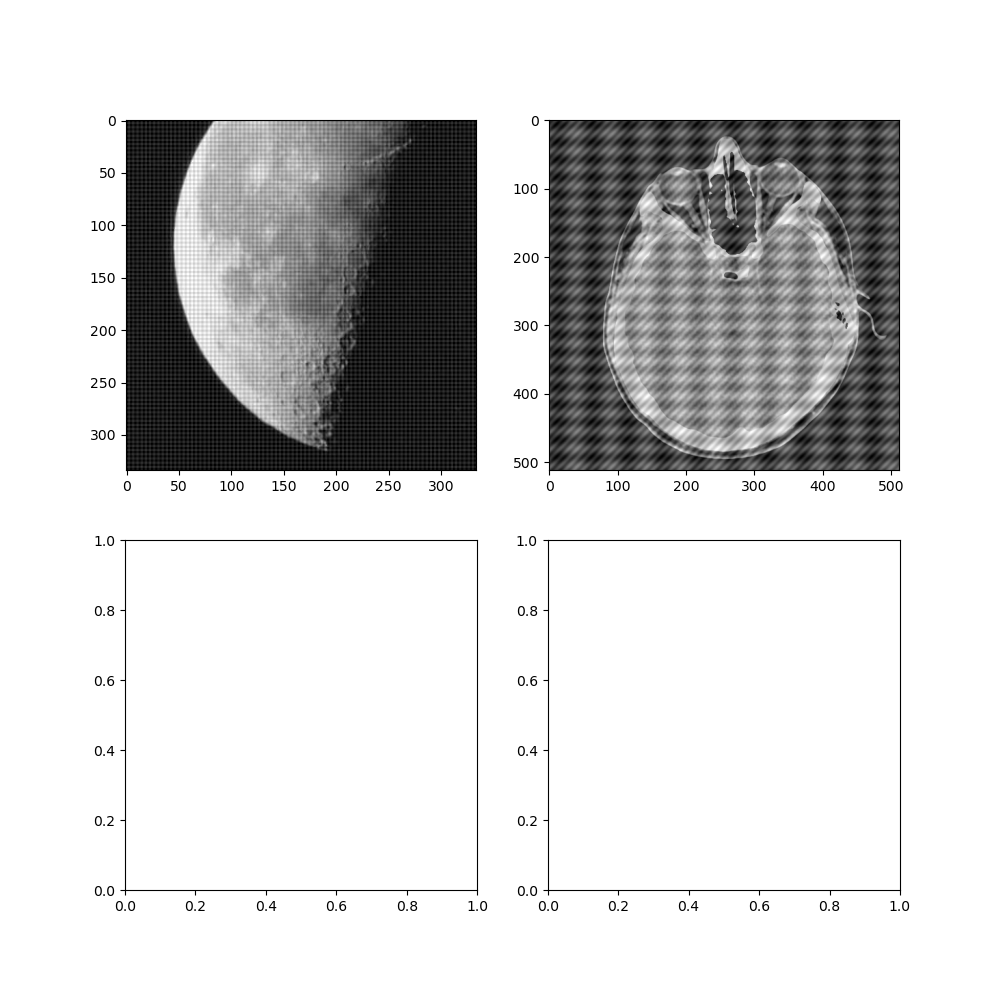

In [333]:
noisy_moon = cv.imread("imagenes/noisy_moon.jpg",cv.IMREAD_GRAYSCALE)
noisy_head = cv.imread("imagenes/HeadCT_degradada.tif",cv.IMREAD_GRAYSCALE)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(noisy_moon,cmap="gray")
ax[0,1].imshow(noisy_head,cmap="gray")
plt.show()

# ejercicio 6

In [351]:
def wienerFilter(imagen,r,snr):
    im0_H, im0_W = imagen.shape

    h_psf = cv.circle(np.zeros(imagen.shape),(im0_W//2,im0_H//2), r,(255,255,255),-1)
    h_psf = h_psf/np.sum(h_psf)

    H_psf = np.fft.fft2(h_psf).real
    H_psf_mc = np.fft.fftshift(cv.magnitude(H_psf,np.zeros(H_psf.shape)))

    Hw = np.divide(H_psf,np.power(np.abs(H_psf),2) + 1/snr)
    return Hw

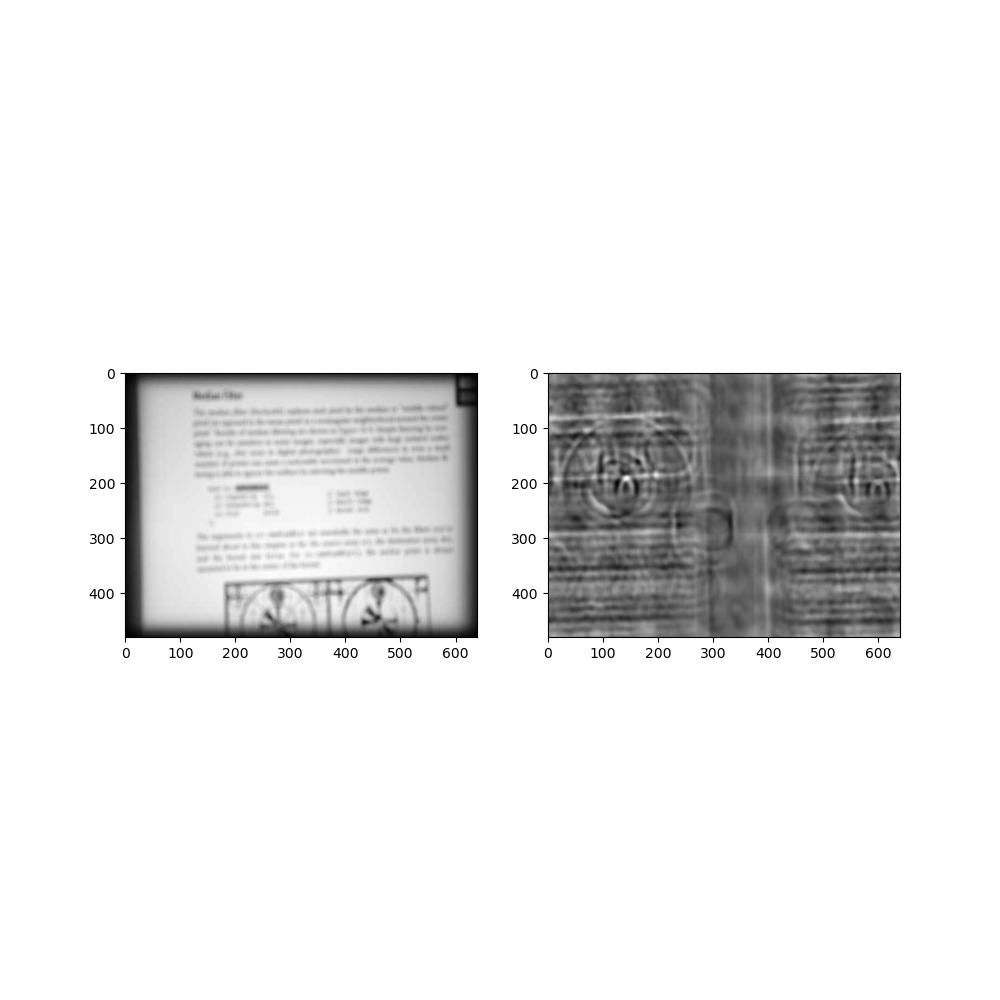

In [354]:
imagen = cv.imread("imagenes/original.jpg",cv.IMREAD_GRAYSCALE)

filtroWiener = wienerFilter(imagen,53,5200)
imgWiener = filterImg(imagen,filtroWiener)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10)) 
ax[0].imshow(imagen,cmap="gray")
ax[1].imshow(imgWiener,cmap="gray")
plt.show()



# ejercicio 7

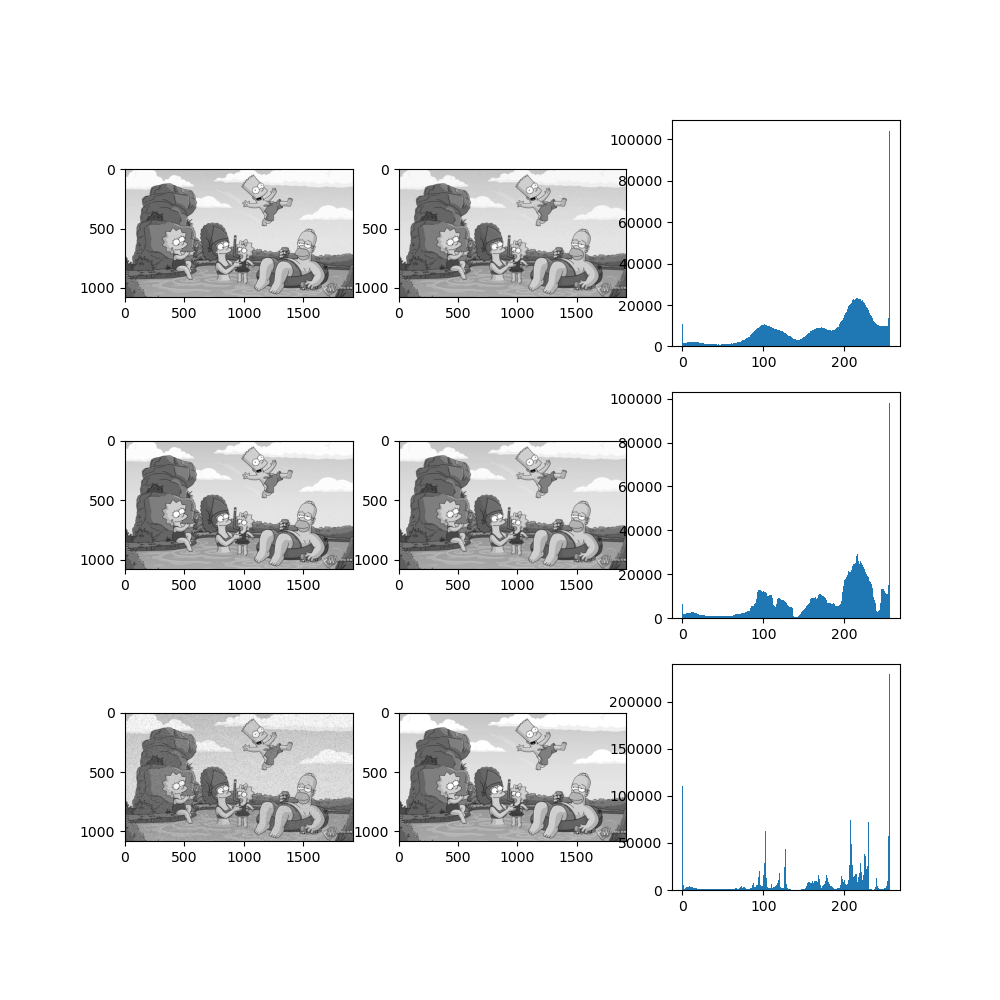

In [368]:
im0 = cv.imread('imagenes/FAMILIA_a.jpg', cv.IMREAD_GRAYSCALE)
im1 = cv.imread('imagenes/FAMILIA_b.jpg', cv.IMREAD_GRAYSCALE)
im2 = cv.imread('imagenes/FAMILIA_c.jpg', cv.IMREAD_GRAYSCALE)
im0_H, im0_W = im0.shape


im0_filtrada = punto_medio(im0,3)
im1_filtrada = punto_medio(im1, 3)
im2_filtrada = cv.medianBlur(im2, 3)


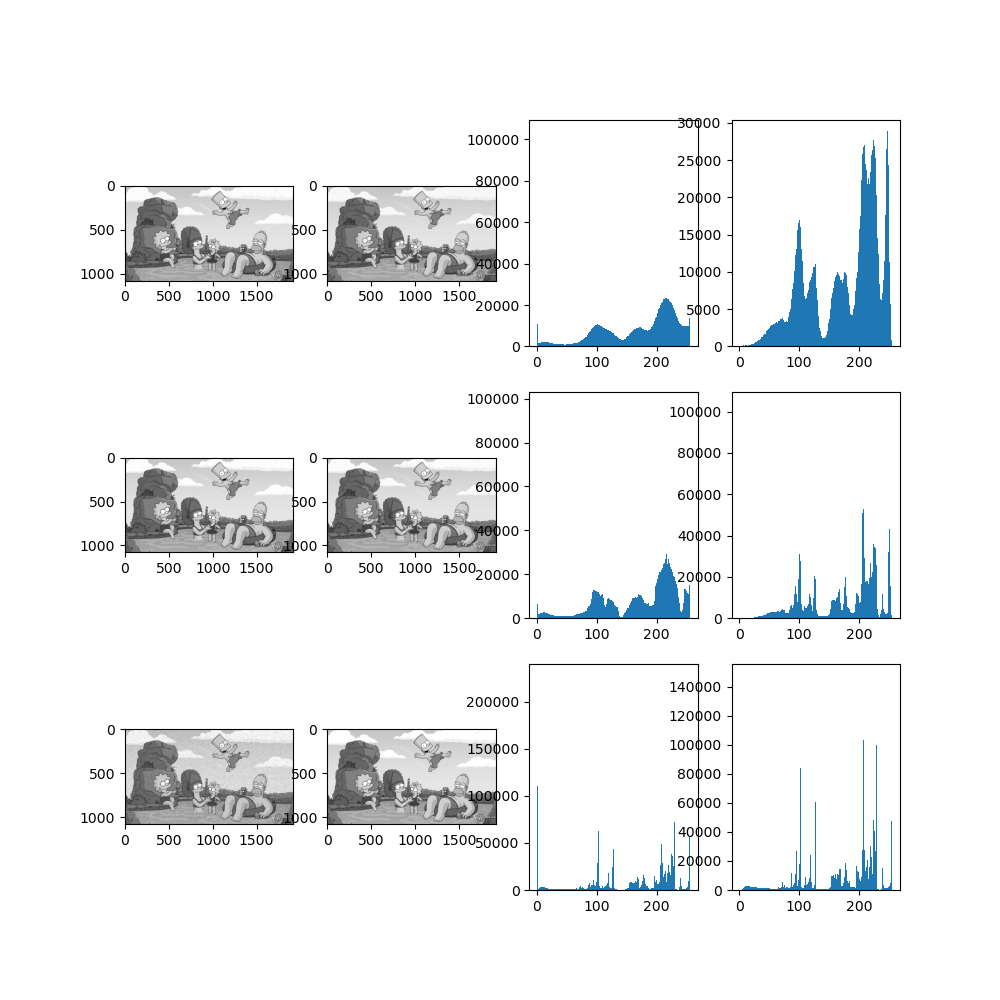

In [370]:

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10,10)) 
ax[0,0].imshow(im0,cmap="gray")
ax[1,0].imshow(im1,cmap="gray")
ax[2,0].imshow(im2,cmap="gray")


ax[0,1].imshow(im0_filtrada,cmap='gray',vmin=0,vmax=255)
ax[1,1].imshow(im1_filtrada,cmap='gray',vmin=0,vmax=255)
ax[2,1].imshow(im2_filtrada,cmap='gray',vmin=0,vmax=255)

ax[0,2].hist(im0.ravel(),256,[0,256])
ax[1,2].hist(im1.ravel(),256,[0,256])
ax[2,2].hist(im2.ravel(),256,[0,256])

ax[0,3].hist(im0_filtrada.ravel(),256,[0,256])
ax[1,3].hist(im1_filtrada.ravel(),256,[0,256])
ax[2,3].hist(im2_filtrada.ravel(),256,[0,256])
plt.show()
